# Exploring RNNs
In this notebook, we will be creating a simple Elman-type recurrent neural network (RNN) followed by implementing backpropagation through time (BPTT) to train the RNN on 2D hand-drawn trajectories.

The Elman-type RNN is a 3-layered network with a recurrent hidden (context) layer, with the following structure:
- $\mathbf{x}_t$ as the input
- $\mathbf{c}_t$ as the internal state
- $\widehat{\mathbf{y}}_{t+1}$ as the output.

The network is defined by the following equations:
$$\begin{align*}
\mathbf{c}_{t+1} &= \boldsymbol{\theta}(\underbrace{\mathbf{W}^{cc}\mathbf{c}_t + \mathbf{W}^{cx}\mathbf{x}_{t} + \mathbf{b}^c}_{\mathbf{s}^c_{t+1}}) \\
\widehat{\mathbf{y}}_{t+1} &= \boldsymbol{\phi}(\underbrace{\mathbf{W}^{yc}\mathbf{c}_{t+1} + \mathbf{b}^y}_{\mathbf{s}^{y}_{t+1}}),
\end{align*}$$
where $\boldsymbol{\theta}(\cdot)$ and $\boldsymbol{\phi}(\cdot)$ are vectorized activation functions (e.g. ReLU and sigmoid) and $\mathbf{c}_0$ is a trainable initial context state that plays a key role in capturing the starting conditions of each trajectory.

We will use squared Euclidean distance from the trajectory at every timestep as the loss function to train the network:
$$E_t(\Omega) = ||\mathbf{y}_t - \widehat{\mathbf{y}}_t||^2, \quad t \geq 1$$
where the row vectors $\widehat{\mathbf{y}}_t$ and $\mathbf{y}_t$ are the predicted and target trajectory points, respectively, at timestep $t$, and $\Omega$ is the set of trainable model parameters (e.g. weights and biases) in our network.

## 1. Getting the Data
We will start with the preliminaries like importing the necessary libraries and creating a canvas to draw the training data. Datasets for different trajectory sequences can be created (hand-drawn) on this canvas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipycanvas import Canvas, hold_canvas
import ipywidgets as widgets
from IPython.display import display
import os

In [2]:
canvas_width = 400
canvas_height = 400
canvas = Canvas(width=canvas_width, height=canvas_height)
bgcolor = "#D3D3D3" # lightgrey
canvas.fill_style = bgcolor
canvas.fill_rect(0, 0, canvas_width, canvas_height)
display(canvas)

traj = []
drawing = False

# event handlers
def handle_mouse_down(x, y):
    global drawing
    drawing = True
    traj.clear()  # start a new trajectory
    traj.append((x, y))
    
def handle_mouse_move(x, y):
    if drawing:
        if not traj:
            return
        # draw a line segment from the previous point to the current one
        prev_x, prev_y = traj[-1]
        with hold_canvas(canvas):
            canvas.stroke_line(prev_x, prev_y, x, y)
        traj.append((x, y))

def handle_mouse_up(x, y):
    global drawing
    if drawing:
        traj.append((x, y))
        drawing = False

canvas.on_mouse_down(handle_mouse_down)
canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_up(handle_mouse_up)

# utility functions
def normalize_trajectory(trj):
    """normalize points to [0, 1] range"""
    normalized_traj = np.array(trj).astype(float)
    # flip y-axis to align with global coordinate system
    normalized_traj[:, 1] = canvas_height - normalized_traj[:, 1]
    # normalize
    normalized_traj[:, 0] /= canvas_width
    normalized_traj[:, 1] /= canvas_height
    return normalized_traj

def resample_trajectory(trj, num_points=100):
    """linearly resample a trajectory to have exactly num_points"""
    curr_traj = np.array(trj)
    original_indices = np.linspace(0, 1, len(curr_traj))
    new_indices = np.linspace(0, 1, num_points)
    resampled_traj = np.zeros((num_points, curr_traj.shape[1]))
    # interpolate each dimension independently
    for i in range(curr_traj.shape[1]):
        resampled_traj[:, i] = np.interp(new_indices, original_indices, curr_traj[:, i])
    return resampled_traj

# ui elements
file_name_text = widgets.Text(
    value='./data/new_trajectory.npz',
    description='File name:',
    placeholder='Enter file name...'
)

clear_button = widgets.Button(description="Clear Canvas")
def clear_canvas(b):
    canvas.clear()
    traj.clear()
    canvas.fill_rect(0, 0, canvas_width, canvas_height)
clear_button.on_click(clear_canvas)

save_button = widgets.Button(description="Save Trajectory")
def save_trajectory(b):
    if len(traj) < 2:
        print("Not enough points drawn. Please draw a trajectory first.")
        return
    curr_traj = np.array(traj)
    traj_normalized = normalize_trajectory(curr_traj)
    traj_resampled = resample_trajectory(traj_normalized, num_points=100)
    file_path = file_name_text.value
    directory = os.path.dirname(file_path)
    if directory and not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)
    np.savez(file_name_text.value, trajectory=traj_resampled)
    print("Trajectory saved to {}".format(file_path))

save_button.on_click(save_trajectory)

# display widgets
display(widgets.HBox([clear_button, file_name_text, save_button]))

Canvas(height=400, width=400)

## 2. Implementing the RNN
### 2.1 Preliminaries
The forward pass of the network is defined in the section above. We will begin by creating the loss and activation function classes as well as the overall `RNN` class with dense fully connected input, output, and a stateful hidden context layer.

In [3]:
# activation functions
class ReLU:
    # relu = max(x, 0)
    @staticmethod
    def __call__(x):
        return np.maximum(x, 0)
    # derivative of relu
    @staticmethod
    def prime(x):
        return np.where(x > 0.0, 1.0, 0.0)

class Sigmoid:
    # sigmoid = 1 / (1 + exp(-x))
    @staticmethod
    def __call__(x):
        return 1/(1 + np.exp(-x))
    # derivative of sigmoid
    @staticmethod
    def prime(x):
        sigmoid = Sigmoid()(x)
        return sigmoid*(1 - sigmoid)
    
class Tanh:
    # tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
    @staticmethod
    def __call__(x):
        return np.tanh(x)
    # derivative of tanh
    @staticmethod
    def prime(x):
        return 1 - np.tanh(x)**2

We will denote an individual weight $w^{ab}_{i,j}$ to be along an edge connecting node $j$ in layer $b$ to node $i$ in layer $a$, representing an entry in the corresponding weight matrix $\mathbf{W}^{ab}$ under conventional row-column indexing. The preactivation input at layer $a$ is given by $\mathbf{s}^{a} = \mathbf{W}^{ab}\mathbf{x}^{b} + \mathbf{b}^{a}$ with the corresponding layer activation $\mathbf{x}^{a} = \boldsymbol{\theta}^{a}(\mathbf{s}^a)$.

To prompt effective and stable learning in simple RNNs, we follow this [paper](https://arxiv.org/abs/1511.03771v3) to initialize all weights. Accordingly, the feedforward weights $\mathbf{W}^{cx} \in \mathbb{R}^{n_c \times n_x}$ are drawn independently from a zero-mean Gaussian distribution with variance $1/{n_c}$, and are further scaled by a factor $$\alpha = \sqrt{2}\exp\left(\frac{1.2}{\max(n_c, 6)-2.4}\right).$$
Similarly, the weights $\mathbf{W}^{yc} \in \mathbb{R}^{n_y \times n_c}$ follow the Xavier (Glorot) initialization scheme and are drawn independently from a Gaussian distribution with variance $2/(n_c+n_y)$.
The recurrent weights $\mathbf{W}^{cc} \in \mathbb{R}^{n_c \times n_c}$ are initialized to form a positive-definite (random) matrix with the highest eigenvalue of unity. Specifically, starting with a standard normal matrix $\mathbf{R} \in \mathbb{R}^{n_c \times n_c}$, we perform the following computations:
$$\begin{align*}
\mathbf{P} &= \mathbf{I} + \frac{\mathbf{R}^\top\mathbf{R}}{n_c} \\
\mathbf{W}^{cc} &= \frac{\mathbf{P}}{\max\left(\lambda\left(\mathbf{P}\right)\right)},
\end{align*}$$
where $\lambda(\mathbf{P})$ is the set of all eigenvalue magnitudes of matrix $\mathbf{P}$. All the biases are set to zero. All entries in the initial context vectors $\mathbf{c}_0$ are drawn independently from a zero-mean Gaussian distribution with variance $1/{n_c}$.

In [4]:
class RNN:
    """
    simple RNN with one hidden, stateful context layer that is trainable for multiple sequences with shared 
    weights and biases but different starting contexts
    """
    def __init__(self, input_dim, hidden_dim, output_dim, activations, seqIDs=[]):
        # seqIDs needed to store sequence-wise initial contexts
        # network parameters are initialized according to https://arxiv.org/abs/1511.03771v3
        assert len(activations) == 2
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.activations  = activations
        self.seqIDs = seqIDs

        # Wcx: i.i.d. entries ~ scaled Gaussian distribution (mu=0, sigma^2=1/hidden_dim, scaled by alpha)
        alpha = np.sqrt(2) * np.exp(1.2/(max(hidden_dim, 6) - 2.4))
        self.Wcx = (alpha/np.sqrt(hidden_dim)) * np.random.randn(hidden_dim, input_dim)

        # Wcc: initialized to a random positive-definite matrix with highest eigval of unity
        R = np.random.randn(hidden_dim, hidden_dim)
        P = np.eye(hidden_dim) + (R.T @ R) / hidden_dim
        e = np.max(np.abs(np.linalg.eigvals(P)))
        self.Wcc = P / e

        # Wyc: i.i.d. entries ~ Gaussian distribution (mu=0, sigma^2=2/(n_in+n_out))
        # this scheme is also known as the Xavier or Glorot initialization
        self.Wyc = np.random.randn(output_dim, hidden_dim) / np.sqrt((output_dim+hidden_dim)/2)

        # initialize biases (according to the Glorot scheme)
        self.bc = np.zeros((hidden_dim,))
        self.by = np.zeros((output_dim,))

        # dictionary of initial contexts for each sequence (and its copy for stateful compute)
        self.c0 = {seqID: np.random.randn(hidden_dim,)/np.sqrt(hidden_dim) for seqID in seqIDs}
        self.ct = {seqID: np.copy(self.c0[seqID]) for seqID in seqIDs}

    def add_seqID(self, seqID):
        self.seqIDs.append(seqID)
        self.c0[seqID] = np.random.randn(self.hidden_dim, 1)/np.sqrt(self.hidden_dim)
        self.ct[seqID] = np.copy(self.c0[seqID])

    def remove_seqID(self, seqID):
        self.seqIDs.remove(seqID)
        del self.c0[seqID]
        del self.ct[seqID]
    
    def get_c0(self, seqID):
        assert seqID in self.seqIDs
        return np.copy(self.c0[seqID])

    def get_ct(self, seqID):
        assert seqID in self.seqIDs
        return np.copy(self.ct[seqID])

    def step_stateless(self, x, c):
        """perform a single step of forward propagation (memoryless)"""
        cnxt = self.activations[0](self.Wcx @ x + self.Wcc @ c + self.bc)
        ynxt = self.activations[1](self.Wyc @ cnxt + self.by)
        return ynxt, cnxt

    def step_stateful(self, x, seqID):
        """perform a single step of forward propagation (with memory)"""
        assert seqID in self.seqIDs
        self.ct[seqID] = self.activations[0](self.Wcx @ x + self.Wcc @ self.ct[seqID] + self.bc)
        y = self.activations[1](self.Wyc @ self.ct[seqID] + self.by)
        return y

    def update_c0(self, c0, seqID):
        assert seqID in self.seqIDs
        self.c0[seqID] = np.copy(c0)
        self.reset_ct(seqID)

    def reset_ct(self, seqID):
        assert seqID in self.seqIDs
        self.ct[seqID] = self.get_c0(seqID)

    def fwd_prop(self, x, T, seqID):
        """
        forward propagation over next T time steps by closing the input-output loop
        output: yt = [y_0|y_1| ... |y_T], ct = [c_0|c_1| ... |c_T]
        """
        c = self.get_c0(seqID)
        yt = np.concatenate((x.reshape(-1,1), np.zeros((self.output_dim, T))), axis=1)
        ct = np.concatenate((c.reshape(-1,1), np.zeros((self.hidden_dim, T))), axis=1)
        for t in range(1, T+1):
            yt[:, t], ct[:, t] = self.step_stateless(yt[:, t-1], ct[:, t-1])
        return yt, ct

The accuracy of the network at any instant will be estimated by calculating the net loss (i.e. the sum of deviation errors at each timestep) over the entire sequence length given a fixed set of parameters, 
$$E_\text{tot} = \sum_{1 \leq t \leq T} E_t(\Omega).$$

In [7]:
# step loss and net loss functions
class SquaredNormLoss:
    # loss = ||y - yhat||^2 for y, yhat in R^n (output_dim)
    @staticmethod
    def __call__(y, yhat):
        return np.sum((y - yhat)**2) # current squared error
    
    # derivative with respect to input (yhat)
    @staticmethod
    def prime(y, yhat):
        return 2*(y - yhat)

def netloss(ys, yshat):
    """expects ys and yshat to be of shape (output_dim, T)"""
    assert ys.shape == yshat.shape
    return np.sum((ys[:, 1:] - yshat[:, 1:])**2) # net squared error

We will run a forward pass on an untrained, newly initialized network and test for its accuracy to see if our implementation is functional thus far. We source the data from section 3 just for this purpose.

Net Loss: 21.5566


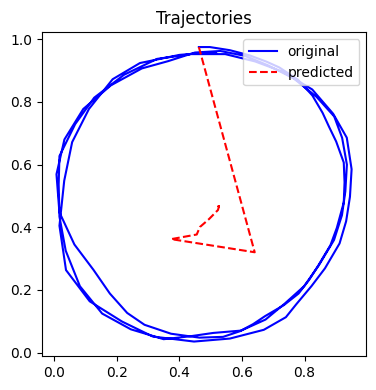

In [106]:
# test forward propagation and loss functions
rnn = RNN(2, 2, 2, [ReLU(), Sigmoid()], seqIDs=['test-run'])
circ_traj = np.load('./data/circle1.npz')['trajectory'].T
pred_traj, _ = rnn.fwd_prop(circ_traj[:, 0], circ_traj.shape[1]-1, 'test-run')
loss = netloss(circ_traj, pred_traj)
print("Net Loss: {:.4f}".format(loss))
# plot the trajectories for comparison
plt.figure(figsize=(4, 4))
plt.plot(circ_traj[0], circ_traj[1], 'b-', label='original')
plt.plot(pred_traj[0], pred_traj[1], 'r--', label='predicted')
plt.title('Trajectories')
plt.legend(loc='upper right')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

### 2.2 BPTT Derivation and Implementation
Here we will use a particular style of BPTT for RNNs, called Teacher Forcing, wherein output at each timestep matters and is sought to be aligned to the input sequence. To ensure good generalization, we will train on multiple sequences of the _same kind_.

BPTT involves unrolling the recurrent network by repeating the hidden layer (in the corresponding feedforward computational graph) to calculate the output for the next timestep. Based on the error at that timestep, new gradients are backpropagated and are eventually accumulated to update all trainable parameters in the network based on sequence prediction (or regeneration) errors. Below, we lay out the recursive backpropagation equations along with the base case for the input layer.

Following the delta-rule for backpropagating errors through dense networks with vectorized layer activations, we define
$\boldsymbol{\delta}^a \coloneqq \frac{\partial E_t}{\partial \mathbf{s}^a}$. In the base case, we compute the gradients based on the first (feedforward) prediction step of the network, i.e. at $t=1$:
$$\begin{align*}
\boldsymbol{\delta}^y_1 = \boldsymbol{\phi}^\prime&\left(\mathbf{s}_1^y\right)\odot\frac{\partial E_1}{\partial \widehat{\mathbf{y}}} \tag{o1}\\
\frac{\partial E_1}{\partial \mathbf{W}^{yc}} = \boldsymbol{\delta}^y_1&\mathbf{c}_1^\top, \quad \frac{\partial E_1}{\partial \mathbf{b}^{y}} = \boldsymbol{\delta}^y_1 \tag{o2}\\
\boldsymbol{\delta}^c_1 = \boldsymbol{\theta}^\prime&\left(\mathbf{s}_1^c\right) \odot \mathbf{W}^{yc\top}\boldsymbol{\delta}^y_1 \tag{o3}
\end{align*}$$
$$\begin{equation*}
\boxed{
\frac{\partial E_t}{\partial \mathbf{W}^{cc}} = \boldsymbol{\delta}^c_1\mathbf{c}_0^\top, \quad \frac{\partial E_t}{\partial \mathbf{W}^{cx}} = \boldsymbol{\delta}^c_1\mathbf{x}_0^\top, \quad \frac{\partial E_t}{\partial \mathbf{b}^{c}} = \boldsymbol{\delta}^c_1, \quad \frac{\partial E_t}{\partial \mathbf{c}_0} = \mathbf{W}^{cc\top}\boldsymbol{\delta}^c_1.
}
\tag{i1}
\end{equation*}$$

The case for $t>1$ (here shown for $t=2$) becomes:
$$\begin{align*}
\boldsymbol{\delta}^y_2 = \boldsymbol{\phi}^\prime\left(\mathbf{s}_2^y\right)&\odot\frac{\partial E_2}{\partial \widehat{\mathbf{y}}} \\
\frac{\partial E_2}{\partial \mathbf{W}^{yc}} = \boldsymbol{\delta}^y_2\mathbf{c}_2^\top&, \quad \frac{\partial E_2}{\partial \mathbf{b}^{y}} = \boldsymbol{\delta}^y_2\\
\boldsymbol{\delta}^c_2 = \boldsymbol{\theta}^\prime\left(\mathbf{s}_2^c\right)&\odot\mathbf{W}^{yc\top}\boldsymbol{\delta}^y_2 \\[4mm]
\frac{\partial E_2}{\partial \mathbf{W}^{cc}} = \boldsymbol{\delta}^c_2\mathbf{c}_1^\top, \quad \frac{\partial E_2}{\partial \mathbf{W}^{cx}} &= \boldsymbol{\delta}^c_2\mathbf{x}_1^\top, \quad \frac{\partial E_2}{\partial \mathbf{b}^{c}} = \boldsymbol{\delta}^c_2 \tag{h1}\\
\boldsymbol{\delta}^c_1 = \boldsymbol{\theta}^\prime\left(\mathbf{s}_1^c\right)&\odot\mathbf{W}^{cc\top}\boldsymbol{\delta}^c_2 \tag{h2}
\end{align*}$$
$$\ldots \quad \text{invoke base case above (i1).}$$

Note that all the same-parameter gradients are summed over backpropagation for each timestep and the entire unrolling.

### 2.3 Fine-tuning
Although many ways to fine-tune RNNs exist and can be further envisioned, for now, we will initially train the network using the teacher forcing paradigm and then move to unrolling the network by feeding back its previous output and applying the corresponding backpropagation of errors at each step. This will also require slightly modified gradients than derived above. The change particularly lies in tying the gradients for the hidden layer to its output as well since $\mathbf{x}_t = \widehat{\mathbf{y}}_t$ for $t \geq 1$. Therefore, equations $(\text{h}1)$ and $(\text{h}2)$ need to be updated to the following for $1 \leq \tau \leq t-1$:
    $$\begin{align*}
    \frac{\partial E_t}{\partial \mathbf{W}^{cc}} = \boldsymbol{\delta}^c_{\tau+1}\mathbf{c}_\tau^\top, \quad&\frac{\partial E_t}{\partial \mathbf{W}^{cx}} = \boldsymbol{\delta}^c_{\tau+1}\widehat{\mathbf{y}}_\tau^\top, \quad \frac{\partial E_t}{\partial \mathbf{b}^{c}} = \boldsymbol{\delta}^c_{\tau+1} \tag{h\(1^\prime\) a}\\[2mm]
    \boldsymbol{\delta}^y_\tau = \boldsymbol{\phi}^\prime(\mathbf{s}^y_\tau) \odot \mathbf{W}^{cx\top}\boldsymbol{\delta}^c_{\tau+1}&, \quad \frac{\partial E_t}{\partial \mathbf{W}^{yc}} = \boldsymbol{\delta}^y_{\tau}\mathbf{c}^\top_\tau, \quad \frac{\partial E_t}{\partial \mathbf{b}^{y}} = \boldsymbol{\delta}^y_\tau \tag{h\(1^\prime\) b} \\[4mm]
    \boldsymbol{\delta}^c_\tau = \frac{\partial \mathbf{c}_\tau}{\partial \mathbf{s}^c_\tau}\frac{\partial \mathbf{s}^c_{\tau+1}}{\partial \mathbf{c}_\tau}\frac{\partial E_t}{\partial \mathbf{s}^c_{\tau+1}} &+ \frac{\partial \mathbf{c}_\tau}{\partial \mathbf{s}^c_\tau}\frac{\partial \mathbf{s}^y_\tau}{\partial \mathbf{c}_\tau}\frac{\partial \mathbf{y}_\tau}{\partial \mathbf{s}^y_\tau}\frac{\partial \mathbf{s}^c_{\tau+1}}{\partial \mathbf{y}_\tau}\frac{\partial E_t}{\partial \mathbf{s}^c_{\tau+1}} \\
    = \boldsymbol{\theta}^\prime\left(\mathbf{s}_\tau^c\right)\odot\Big(\mathbf{W}^{cc\top} &+ \mathbf{W}^{yc\top}\text{diag}\left(\boldsymbol{\phi}^\prime\left(\mathbf{s}^y_\tau\right)\right)\mathbf{W}^{cx\top} \Big)\boldsymbol{\delta}^c_{\tau+1}. \tag{h\(2^\prime\)}
    \end{align*}$$

We will now implement BPTT and then write the network training loop in the next section.

In [ ]:
def bptt(self, ys, loss, T, alpha, fine_tune):
    # makes more sense to do a full forward rollout till T and then backprop
        # store the step inputs and outputs at each step for backprop
    # loop through seqIDs in random order per epoch
    grad_weights, grad_biases, grad_c0 = {}, {}, {}
    return grad_weights, grad_biases, grad_c0

## 3. Fitting to the Data

### 3.1 Training and Applying Gradients
We will multiply by the learning rate $\alpha=0.001$

In [ ]:
def train(self, ys, T=30, epochs=1000, alpha=0.001, fine_tune=False):
    loss_hist = np.empty((0,ys.shape[1]), float)

    for epoch in range(epochs):
        # apply gradient descent
        grad_weights, grad_biases = self.bptt(seqID, ys, loss, fine_tune=fine_tune)
        
        self.apply_gradients(grad_weights, grad_biases)

        # compute current loss and accuracy
        outputs   = []
        loss_hist = []

        # print progress
        if epoch % 20 == 0:
            print(f"Epoch {epoch} | Net training Loss: {loss_hist[-1, 0]}")

    return self.weights, self.biases, loss_hist

## 4. "Generating" the Data: Autonomous Dynamical System


## 5. Context State Analysis

### 5.1 Context Manifold
See how the context evolves.

### 5.2 Perturbation Analysis
See if the attractors are stable and when a transition could happen. Plot phase space. Perturb in both x and c.
